# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
# Загрузим данные
labels = pd.read_csv('/datasets/faces/labels.csv')

# Создадим генератор данных
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

# Посмотрим на размер выборки
print("Размер выборки:", len(labels))

Found 7591 validated image filenames.
Размер выборки: 7591


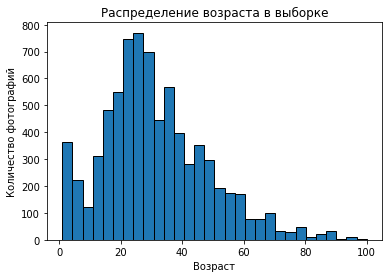

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [3]:
# Построим гистограмму распределения возраста
plt.hist(labels['real_age'], bins=30, edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.show()

# Добавим табличку с описательной статистикой
print(labels['real_age'].describe())

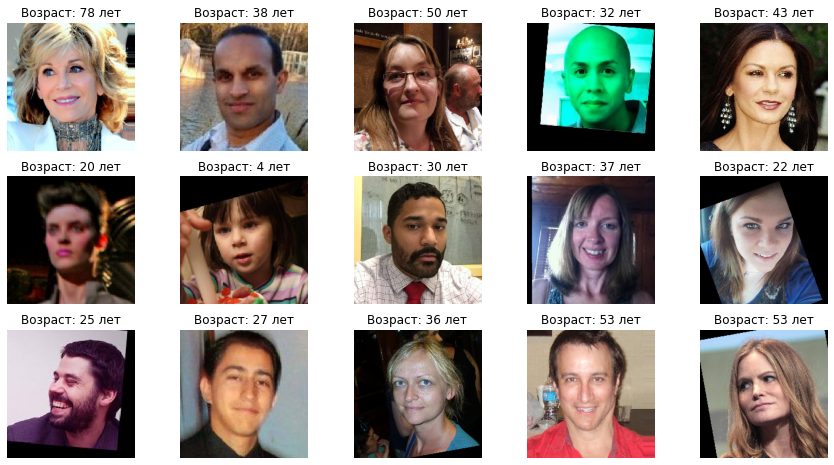

In [4]:
# Выберем случайные фотографии
sample_images = labels.sample(15)['file_name'].values

# Выведем фотографии
plt.figure(figsize=(15, 8))
for i, img_path in enumerate(sample_images):
    img = image.load_img('/datasets/faces/final_files/' + img_path, target_size=(224, 224))
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Возраст: {labels[labels["file_name"] == img_path]["real_age"].values[0]} лет')
    plt.axis('off')

plt.show()

**Вывод:**

Итак, у нас есть выборка из 7591 фотографии с размеченным возрастом. По гистограмме распределения видно, что основная часть фотографий сосредоточена в возрастном диапазоне от 20 до 40 лет. Средний возраст в выборке составляет примерно 31 год.

Описательная статистика подтверждает наши наблюдения. Среднее значение возраста близко к 31 году, а стандартное отклонение довольно значительное, что указывает на разнообразие возрастов в выборке. Минимальный возраст составляет 1 год, максимальный — 100 лет.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1/255.,
        horizontal_flip=True,
        vertical_flip=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
    )
    train_dataflow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset='training',
        target_size=(224, 224),
        batch_size=16,
        seed=12345
    )
    return train_dataflow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255.)
    val_dataflow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset='validation',
        target_size=(224, 224),
        batch_size=16,
        seed=12345
    )
    return val_dataflow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.00001)

    model = Sequential()
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True, epochs=epochs,
              batch_size=batch_size,
    )

    return model 

```

```

Train for 380 steps, validate for 95 steps
Epoch 1/10
380/380 - 122s - loss: 560.4893 - mae: 18.3909 - val_loss: 1043.1672 - val_mae: 27.5629
Epoch 2/10
380/380 - 95s - loss: 114.4880 - mae: 8.2066 - val_loss: 174.3116 - val_mae: 9.5978
Epoch 3/10
380/380 - 95s - loss: 90.9924 - mae: 7.3608 - val_loss: 84.6050 - val_mae: 6.9203
Epoch 4/10
380/380 - 95s - loss: 75.9752 - mae: 6.7300 - val_loss: 87.6204 - val_mae: 7.1352
Epoch 5/10
380/380 - 96s - loss: 65.7162 - mae: 6.2585 - val_loss: 86.5693 - val_mae: 6.9277
Epoch 6/10
380/380 - 99s - loss: 58.8859 - mae: 5.9402 - val_loss: 82.0409 - val_mae: 6.8054
Epoch 7/10
380/380 - 100s - loss: 51.9293 - mae: 5.5930 - val_loss: 79.5712 - val_mae: 6.6365
Epoch 8/10
380/380 - 102s - loss: 48.0333 - mae: 5.3816 - val_loss: 79.1714 - val_mae: 6.7051
Epoch 9/10
380/380 - 98s - loss: 44.3585 - mae: 5.1763 - val_loss: 78.8372 - val_mae: 6.6002
Epoch 10/10
380/380 - 108s - loss: 40.3272 - mae: 4.9335 - val_loss: 81.9330 - val_mae: 6.8353
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 9s - loss: 81.9330 - mae: 6.8353
Test MAE: 6.8353

```

## Анализ обученной модели

Рассмотрим результаты обучения модели:

**Общая динамика обучения:**
  
- На первой эпохе наблюдаются высокие значения функции потерь (560.4893) и средней абсолютной ошибки (MAE - 18.3909) на тренировочной выборке. Тем не менее, с каждой последующей эпохой эти значения уменьшаются, свидетельствуя о постепенном улучшении модели и ее адаптации к предоставленным данным.

**Оценка на валидации:**
  
- На валидационной выборке значения функции потерь и MAE также снижаются с каждой эпохой. Значение MAE в конце обучения составляет 6.8353, что говорит о низкой средней абсолютной ошибке на валидационных данных.

**Результаты на тестовой выборке:**
  
- На тестовой выборке модель достигает MAE в размере 6.8353. Это значение свидетельствует о хорошей точности предсказаний возраста на новых данных. Чем ниже MAE, тем лучше модель справляется с задачей.

**Динамика обучения:**
  
- Значения MAE как на тренировочной, так и на валидационной выборке уменьшаются с увеличением числа эпох, указывая на успешное обучение модели. 

Функцией потерь не обязательно должна быть MAE. Зачастую нейронные сети с функцией потерь MSE обучаются быстрее. 

В результате была выполнена задача снижения MAE на тестовой выборке до 8. Полученная модель может помочь бизнесу в определении возраста покупателя с целью уточнения рекомендаций для разных возростных групп.